## Stacking the Best Models
<pre><b>
This Kernel shows how the scores can be improved using Stacking Method.
Credit Goes to the following kernels
ref:
1. https://www.kaggle.com/criskiev/distance-is-all-you-need-lb-1-481
2. https://www.kaggle.com/marcelotamashiro/lgb-public-kernels-plus-more-features
3. https://www.kaggle.com/scaomath/no-memory-reduction-workflow-for-each-type-lb-1-28
4. https://www.kaggle.com/fnands/1-mpnn
</b></pre>

## Stat Stack

In [153]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

In [285]:
sub_path = "chemistry-models"
all_files = os.listdir(sub_path)
all_files

['submission-1.581.csv',
 '.DS_Store',
 'submission-1.619.csv',
 'submission-1.618.csv',
 'submission-1.327.csv',
 'submission-1.681.csv',
 'submission-1.484.csv',
 'submission_keras.csv',
 'submission-1.281.csv',
 'submission-1.674.csv',
 'LGB_2019-08-26_-1.3073.csv',
 'submission_NN.csv']

In [286]:
import warnings
warnings.filterwarnings("ignore")
outs = [pd.read_csv(os.path.join(sub_path, f), index_col=0) for f in all_files]
concat_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "mol" + str(x), range(len(concat_sub.columns))))
concat_sub.columns = cols
concat_sub.reset_index(inplace=True)
concat_sub.head()
ncol = concat_sub.shape[1]

In [287]:
# check correlation
concat_sub.iloc[:,1:ncol].corr()

,mol0,mol1,mol2,mol3,mol4,mol5,mol6,mol7,mol8,mol9,mol10
mol0,1.000000,0.999842,0.999884,0.999865,0.999851,0.999841,0.983448,0.999875,0.991888,0.999941,0.999866
mol1,0.999842,1.000000,0.999893,0.999805,0.999931,0.999854,0.983536,0.999806,0.991967,0.999811,0.999944
mol2,0.999884,0.999893,1.000000,0.999845,0.999899,0.999939,0.983502,0.999845,0.991931,0.999854,0.999914
mol3,0.999865,0.999805,0.999845,1.000000,0.999817,0.999804,0.983412,0.999882,0.991853,0.999847,0.999826
mol4,0.999851,0.999931,0.999899,0.999817,1.000000,0.999859,0.982639,0.999817,0.992624,0.999821,0.999944
mol5,0.999841,0.999854,0.999939,0.999804,0.999859,1.000000,0.983470,0.999804,0.991887,0.999812,0.999874
mol6,0.983448,0.983536,0.983502,0.983412,0.982639,0.983470,1.000000,0.983421,0.953004,0.983420,0.983553
mol7,0.999875,0.999806,0.999845,0.999882,0.999817,0.999804,0.983421,1.000000,0.991848,0.999850,0.999830
mol8,0.991888,0.991967,0.991931,0.991853,0.992624,0.991887,0.953004,0.991848,1.000000,0.991855,0.991974
mol9,0.999941,0.999811,0.999854,0.999847,0.999821,0.999812,0.983420,0.999850,0.991855,1.000000,0.999834


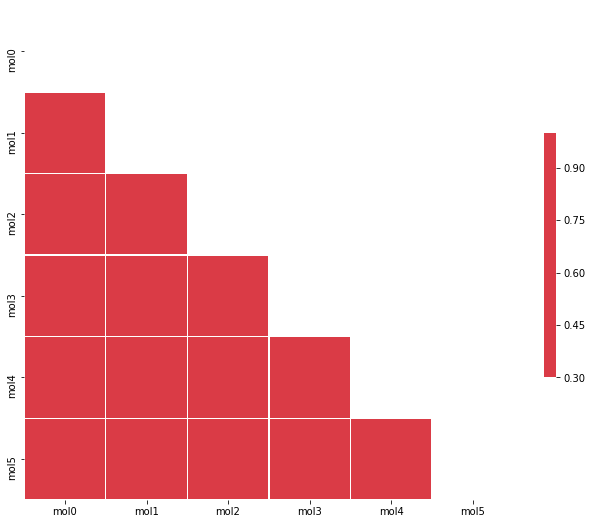

In [288]:
corr = concat_sub.iloc[:,1:7].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [289]:
# get the data fields ready for stacking
concat_sub['m_max'] = concat_sub.iloc[:, 1:ncol].max(axis=1)
concat_sub['m_min'] = concat_sub.iloc[:, 1:ncol].min(axis=1)
concat_sub['m_mean'] = concat_sub.iloc[:, 1:ncol].mean(axis=1)
concat_sub['m_median'] = concat_sub.iloc[:, 1:ncol].median(axis=1)

In [176]:
file_folder = 'champs-scalar-coupling' 
# '../input/champs-scalar-coupling'  (kaggle)
train = pd.read_csv(f'{file_folder}/train.csv')
test = pd.read_csv(f'{file_folder}/test.csv')
sub = pd.read_csv(f'{file_folder}/sample_submission.csv')
structures = pd.read_csv(f'{file_folder}/structures.csv')

In [177]:
y = train['scalar_coupling_constant']
train = train.drop(columns = ['scalar_coupling_constant'])

In [ ]:
from sklearn.linear_model import LassoCV


In [253]:
concat_sub.describe()

,id,mol0,mol1,mol2,mol3,mol4,mol5,mol6,mol7,mol8,mol9,mol10,mol11,mol12,m_max,m_min,m_mean,m_median
count,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06
mean,5.910918e+06,1.588545e+01,1.588928e+01,1.587951e+01,1.592437e+01,1.588214e+01,1.588607e+01,1.587690e+01,1.584992e+01,1.588460e+01,1.588733e+01,1.588603e+01,1.587349e+01,1.588320e+01,1.655972e+01,1.522090e+01,1.588372e+01,1.588128e+01
std,7.232878e+05,3.485832e+01,3.483609e+01,3.485677e+01,3.493039e+01,3.486111e+01,3.486529e+01,3.544416e+01,3.491821e+01,3.513931e+01,3.485936e+01,3.486278e+01,3.482888e+01,3.485671e+01,3.549276e+01,3.508142e+01,3.486203e+01,3.486448e+01
min,4.658147e+06,-3.123325e+01,-3.062161e+01,-3.706147e+01,-2.474941e+01,-3.309956e+01,-3.378963e+01,-1.011903e+04,-2.480539e+01,-3.315324e+01,-3.101862e+01,-3.259560e+01,-3.230405e+01,-3.299384e+01,-2.328606e+01,-1.011903e+04,-2.150830e+02,-3.134178e+01
25%,5.284532e+06,-2.119182e-01,-1.806424e-01,-2.484849e-01,-2.278156e-01,-2.461876e-01,-2.601339e-01,-2.468897e-01,-2.855237e-01,-2.453283e-01,-2.162788e-01,-2.430994e-01,-2.472747e-01,-2.502056e-01,1.842621e-01,-6.220917e-01,-2.132179e-01,-2.345701e-01
50%,5.910918e+06,2.291562e+00,2.340105e+00,2.279487e+00,2.290658e+00,2.278162e+00,2.285192e+00,2.276373e+00,2.208885e+00,2.281530e+00,2.304652e+00,2.280423e+00,2.277905e+00,2.282187e+00,2.804667e+00,1.815201e+00,2.276537e+00,2.274283e+00
75%,6.537303e+06,7.319373e+00,7.062823e+00,7.356561e+00,7.355250e+00,7.355285e+00,7.369593e+00,7.354875e+00,7.274941e+00,7.358020e+00,7.281288e+00,7.353614e+00,7.360947e+00,7.377225e+00,7.932935e+00,6.552587e+00,7.302185e+00,7.331245e+00
max,7.163688e+06,2.036968e+02,2.042145e+02,3.161125e+02,2.057290e+02,2.844774e+02,2.043752e+02,2.149311e+02,2.036779e+02,7.001663e+03,2.037030e+02,2.044570e+02,2.032168e+02,2.085859e+02,7.001663e+03,2.017822e+02,2.049032e+02,2.032168e+02


In [169]:
cutoff_lo = 0.8
cutoff_hi = 0.2

# Mean Stacking

In [170]:
concat_sub['scalar_coupling_constant'] = concat_sub['m_mean']
concat_sub[['id', 'scalar_coupling_constant']].to_csv('stack_mean.csv', 
                                        index=False, float_format='%.6f')

# Median Stacking

In [290]:
concat_sub['scalar_coupling_constant'] = concat_sub['m_median']
concat_sub[['id', 'scalar_coupling_constant']].to_csv('stack_median.csv', 
                                        index=False, float_format='%.6f')

In [185]:
sub_path2 = "median_model"
all_files_median = os.listdir(sub_path2)
all_files_median

['stack_median2.csv', '.DS_Store', 'stack_median3.csv', 'stack_median.csv']

In [186]:
outs_median = [pd.read_csv(os.path.join(sub_path2, f), index_col=0) for f in all_files_median]
concat_sub_median = pd.concat(outs_median, axis=1)
cols_median = list(map(lambda x: "mol" + str(x), range(len(concat_sub_median.columns))))
concat_sub_median.columns = cols_median
concat_sub_median.reset_index(inplace=True)
concat_sub_median.head()
ncol_median = concat_sub_median.shape[1]

In [187]:
concat_sub_median['m_mean'] = concat_sub_median.iloc[:, 1:ncol_median].mean(axis=1)
concat_sub_median['m_median'] = concat_sub_median.iloc[:, 1:ncol_median].median(axis=1)

In [188]:
concat_sub_median['scalar_coupling_constant'] = concat_sub_median['m_mean']
concat_sub_median[['id', 'scalar_coupling_constant']].to_csv('stack_mean_m.csv', 
                                        index=False, float_format='%.6f')

In [196]:
concat_sub_median['scalar_coupling_constant'] = concat_sub_median['m_median']
concat_sub_median[['id', 'scalar_coupling_constant']].to_csv('stack_median_m.csv', 
                                        index=False, float_format='%.6f')

# Pushout + Median Stacking
>* Pushout strategy is bit aggresive

In [140]:
concat_sub['scalar_coupling_constant'] = np.where(np.all(concat_sub.iloc[:,1:ncol] > cutoff_lo, axis=1), 1, 
                                    np.where(np.all(concat_sub.iloc[:,1:ncol] < cutoff_hi, axis=1),
                                             0, concat_sub['m_median']))
concat_sub[['id', 'scalar_coupling_constant']].to_csv('stack_pushout_median.csv', 
                                        index=False, float_format='%.6f')

# MinMax + Mean Stacking
>* MinMax seems more gentle and it outperforms the previous one

In [141]:
concat_sub['scalar_coupling_constant'] = np.where(np.all(concat_sub.iloc[:,1:ncol] > cutoff_lo, axis=1), 
                                    concat_sub['m_max'], 
                                    np.where(np.all(concat_sub.iloc[:,1:ncol] < cutoff_hi, axis=1),
                                             concat_sub['m_min'], 
                                             concat_sub['m_mean']))
concat_sub[['id', 'scalar_coupling_constant']].to_csv('stack_minmax_mean.csv', 
                                        index=False, float_format='%.6f')

# MinMax + Median Stacking

In [142]:
concat_sub['scalar_coupling_constant'] = np.where(np.all(concat_sub.iloc[:,1:ncol] > cutoff_lo, axis=1), 
                                    concat_sub['m_max'], 
                                    np.where(np.all(concat_sub.iloc[:,1:ncol] < cutoff_hi, axis=1),
                                             concat_sub['m_min'], 
                                             concat_sub['m_median']))
concat_sub[['id', 'scalar_coupling_constant']].to_csv('stack_minmax_median.csv', 
                                        index=False, float_format='%.6f')

## Averaging Ranks

In [143]:
concat_sub['scalar_coupling_constant'] = concat_sub['mol0'].rank(method ='min') + concat_sub['mol1'].rank(method ='min') + concat_sub['mol2'].rank(method ='min') 
concat_sub['scalar_coupling_constant'] = (concat_sub['scalar_coupling_constant']-concat_sub['scalar_coupling_constant'].min())/(concat_sub['scalar_coupling_constant'].max() - concat_sub['scalar_coupling_constant'].min())
concat_sub.describe()
concat_sub[['id', 'scalar_coupling_constant']].to_csv('stack_rank.csv', index=False, float_format='%.8f')

Best Results : Stack Median

# Blending Approach

In [144]:
one = pd.read_csv('chemistry-models/submission-1.672.csv')
two = pd.read_csv('chemistry-models/submission-1.674.csv')
three = pd.read_csv('chemistry-models/submission-1.681.csv')

submission = pd.DataFrame()
submission['id'] = one.id
submission['scalar_coupling_constant'] = (0.20*one.scalar_coupling_constant) + (0.35*two.scalar_coupling_constant) + (0.45*three.scalar_coupling_constant)

submission.to_csv('Aggblender_3.csv', index=False)